# Setup
## Import required packages

In [1]:
import math
import sqlite3
import struct
import datetime
import scipy.fftpack
from scipy import signal as sig

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import dates
import numpy as np
from scipy import signal, optimize
from tqdm.notebook import tnrange, tqdm
from IPython.display import set_matplotlib_formats

In [18]:
%matplotlib inline
set_matplotlib_formats('png', 'pdf')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

## Load data series information from sqlite capture file

One capture file may contain multiple runs/data series. Display a list of runs and their start/end time and sample count, then select the newest one in `last_run` variable.

In [3]:
db = sqlite3.connect('data/waveform-raspi-ocxo-temp-1.sqlite3')

In [4]:
for run_id, start, end, count in db.execute('SELECT run_id, MIN(rx_ts), MAX(rx_ts), COUNT(*) FROM measurements GROUP BY run_id'):
    foo = lambda x: datetime.datetime.fromtimestamp(x/1000)
    start, end = foo(start), foo(end)
    time_window = f'{start:%Y-%m-%d %H:%M:%S} - {end:%Y-%m-%d %H:%M:%S}'
    print(f'Run {run_id:03d}: {time_window} ({str(end-start)[:-3]:>13}, {count*32:>9d}sp)')
last_run, n_records = run_id, count

Run 000: 2020-04-01 14:00:25 - 2020-04-01 15:09:31 (  1:09:05.846,   4197664sp)
Run 001: 2020-04-02 11:56:41 - 2020-04-02 11:57:59 (  0:01:18.544,     79552sp)
Run 002: 2020-04-02 12:03:51 - 2020-04-03 14:12:18 (1 day, 2:08:27.650,  95262624sp)


## Setup analog parameters

Setup parameters of analog capture hardware here. This is used to scale samples from ADC counts to analog voltages. Also setup sampling rate here. Nominal sampling rate is 1 ksps.

In [5]:
sampling_rate = 1000.0 * 48.6 / 48

par = lambda *rs: 1/sum(1/r for r in rs) # resistor parallel calculation

# Note: These are for the first prototype only!
vmeas_source_impedance = 330e3
vmeas_source_scale = 0.5

vcc = 15.0
vmeas_div_high = 27e3
vmeas_div_low = par(4.7e3, 10e3)
vmeas_div_voltage = vcc * vmeas_div_low / (vmeas_div_high + vmeas_div_low)
vmeas_div_impedance = par(vmeas_div_high, vmeas_div_low)

#vmeas_overall_factor = vmeas_div_impedance / (vmeas_source_impedance + vmeas_div_impedance)
v0 = 1.5746
v100 = 2.004
vn100 = 1.1452

adc_vcc = 3.3 # V
adc_fullscale = 4095

adc_val_to_voltage_factor = 1/adc_fullscale * adc_vcc

adc_count_to_vmeas = lambda x: (x*adc_val_to_voltage_factor - v0) / (v100-v0) * 100

## Load run data from sqlite3 capture file

Load measurement data for the selected run and assemble a numpy array containing one continuous trace. 

In [6]:
limit = n_records
record_size = 32
skip_dropped_sections = False

data = np.zeros(limit*record_size)
data[:] = np.nan

last_seq = None
write_index = 0
for i, (seq, chunk) in tqdm(enumerate(db.execute(
        'SELECT seq, data FROM measurements WHERE run_id = ? ORDER BY rx_ts LIMIT ? OFFSET ?',
        (last_run, limit, n_records-limit))), total=n_records):
    
    if last_seq is None or seq == (last_seq + 1)%0x10000:
        last_seq = seq
        idx = write_index if skip_dropped_sections else i
        data[idx*record_size:(idx+1)*record_size] = np.frombuffer(chunk, dtype='<H')
        write_index += 1
        
    elif seq > last_seq:
        last_seq = seq
        # nans = np.empty((record_size,))
        # nans[:] = np.nan
        # data = np.append(data, nans) FIXME
        
data = (data * adc_val_to_voltage_factor - v0) / (v100-v0) * 100

# https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
nan_helper = lambda y: (np.isnan(y), lambda z: z.nonzero()[0])

# data rarely may contain NaNs where the capture script failed to read and acknowledge capture buffers from the sensor board fast enough.
# For RMS calculation and overall FFT fill these NaNs with interpolated values from their neighbors.
data_interp = np.copy(data)
nans, x = nan_helper(data)
data_interp[nans]= np.interp(x(nans), x(~nans), data[~nans])

print('RMS voltage:', np.sqrt(np.mean(np.square(data_interp))))


RMS voltage: 227.45673239619953


## Show a preview of loaded data

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


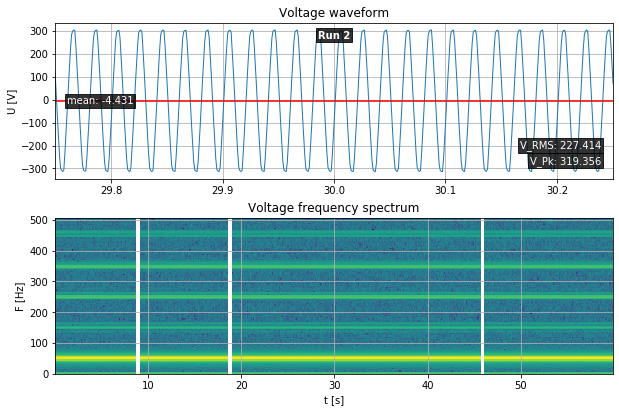

In [19]:
fig, (top, bottom) = plt.subplots(2, figsize=(9,6))
fig.tight_layout(pad=3, h_pad=1.8)

range_start, range_len = -300, 60 # [s]

data_slice = data[ int(range_start * sampling_rate) : int((range_start + range_len) * sampling_rate) ]

top.grid()
top.plot(np.linspace(0, range_len, int(range_len*sampling_rate)), data_slice, lw=1.0)
top.set_xlim([range_len/2-0.25, range_len/2+0.25])
mean = np.mean(data_interp)
rms = np.sqrt(np.mean(np.square(data_interp - mean)))
peak = np.max(np.abs(data_interp - mean))
top.axhline(mean, color='red')
bbox = {'facecolor': 'black', 'alpha': 0.8, 'pad': 2}
top.text(0.02, 0.5, f'mean: {mean:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='left', va='center')
top.text(0.98, 0.2, f'V_RMS: {rms:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='right')
top.text(0.98, 0.1, f'V_Pk: {peak:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='right')
top.text(0.5, 0.9, f'Run {run_id}', transform=top.transAxes, color='white', bbox=bbox, ha='center', fontweight='bold')

bottom.grid()
bottom.specgram(data_slice, Fs=sampling_rate)
top.set_ylabel('U [V]')
bottom.set_ylabel('F [Hz]')
bottom.set_xlabel('t [s]')

top.set_title('Voltage waveform')
bottom.set_title('Voltage frequency spectrum')
None

# Calculate Short-Time Fourier Transform of capture

In [8]:
fs = sampling_rate # Hz
ff = 50 # Hz

analysis_periods = 20
window_len = fs * analysis_periods/ff
nfft_factor = 1
sigma = window_len/8 # samples

f, t, Zxx = signal.stft(data,
            fs = fs,
            window=('gaussian', sigma),
            nperseg = window_len,
            nfft = window_len * nfft_factor)
print(f'Window length: {window_len:.0f} sp, zero-padded to {window_len * nfft_factor:.0f} sp')

Window length: 405 sp, zero-padded to 405 sp


## Show a preview of STFT results

Cut out our approximate frequency range of interest

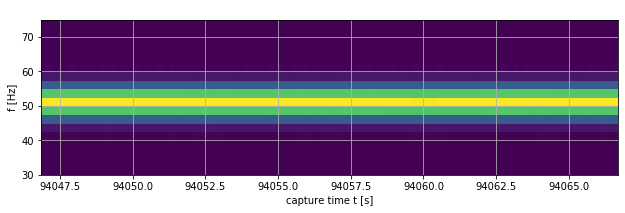

In [53]:
fig, ax = plt.subplots(figsize=(9, 3))
fig.tight_layout(pad=2, h_pad=0.1)

ax.pcolormesh(t[-200:-100], f[:250], np.abs(Zxx[:250,-200:-100]))
ax.set_title(f"Run {last_run}", pad=-20, color='white')
ax.grid()
ax.set_ylabel('f [Hz]')
ax.set_ylim([30, 75]) # Hz
ax.set_xlabel('capture time t [s]')
None

# Run Gasior and Gonzalez for precise frequency estimation

Limit analysis to frequency range of interest. If automatic adaption to totally different frequency ranges
(e.g. 400Hz) would be necessary, we could switch here based on configuration or a lookup of the STFT bin
containing highest overall energy.

As elaborated in the Gasior and Gonzalez Paper [1] the shape of the template function should match the expected peak shape.
Peak shape is determined by the STFT window function. As Gasior and Gonzalez note, a gaussian is a very good fit for a steep gaussian window.

In [10]:
n_f, n_t = Zxx.shape
# Frequency ROI
f_min, f_max = 30, 70 # Hz
# Indices of bins within ROI
bounds_f = slice(np.argmax(f > f_min), np.argmin(f < f_max))

# Initialize output array
f_mean = np.zeros(Zxx.shape[1])

# Iterate over STFT time slices
for le_t in tnrange(1, Zxx.shape[1] - 1):
    # Cut out ROI and compute magnitude of complex fourier coefficients
    frame_f = f[bounds_f]
    frame_Z = np.abs(Zxx[bounds_f, le_t])

    # Template function. We use a gaussian here. This function needs to fit the window above.
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # Calculate initial values for curve fitting
    f_start = frame_f[np.argmax(frame_Z)] # index of strongest bin index
    A_start = np.max(frame_Z) # strongest bin value
    p0 = [A_start, f_start, 1.]
    try:
        # Fit template to measurement data STFT ROI 
        coeff, var = optimize.curve_fit(gauss, frame_f, frame_Z, p0=p0)
        _A, f_mean[le_t], _sigma, *_ = coeff # The measured frequency is the mean of the fitted gaussian
        
    except Exception as e:
        # Handle fit errors
        f_mean[le_t] = np.nan

# Cut off invalid values at fringes
f_mean = f_mean[1:-2]

## Produce a plot of measurement results

Include measurements of mean, standard deviation and variance of measurement data

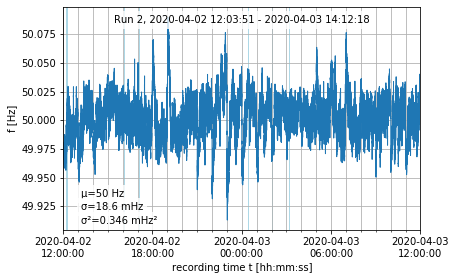

In [89]:
pdate = lambda s: dates.date2num(datetime.datetime.fromisoformat(s))

def plot_freq_trace(outfile, xlim=None, minor_locator=dates.HourLocator(interval=1), major_locator=dates.HourLocator(interval=6)):
    fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
    fig.tight_layout(pad=2.2, h_pad=0, w_pad=1)

    ax.plot([ td2num(td) for td in t[1:-2] ], f_mean, lw=1)
    ax.set_ylabel('f [Hz]')

    var = np.var(f_mean[~np.isnan(f_mean)][1:-1])
    mean = np.mean(f_mean[~np.isnan(f_mean)][1:-1])
    ax.text(0.5,  0.93, f'Run {run_id}, {time_window}', transform=ax.transAxes, ha='center', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.05, 0.15, f'μ={mean:.3g} Hz', transform=ax.transAxes, ha='left', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.05, 0.09, f'σ={np.sqrt(var) * 1e3:.3g} mHz', transform=ax.transAxes, ha='left', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.05, 0.03, f'σ²={var * 1e3:.3g} mHz²', transform=ax.transAxes, ha='left', bbox=dict(fc='white', alpha=0.8, ec='none'))

    # Indicate missing values
    for i in np.where(np.isnan(f_mean))[0]:
        ax.axvspan(td2num(t[i]), td2num(t[i+1]), color='lightblue')

    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    formatter = dates.DateFormatter('%Y-%m-%d\n%H:%M:%S')
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('recording time t [hh:mm:ss]')
    ax.grid(True, which='both')
    if xlim is not None:
        ax.set_xlim(xlim)
    fig.savefig(f'fig_out/{outfile}.pdf')
    None
    
plot_freq_trace('freq_meas_trace_24h',
                xlim=[pdate('2020-04-02 12:00:00'), pdate('2020-04-03 12:00:00')],
               )

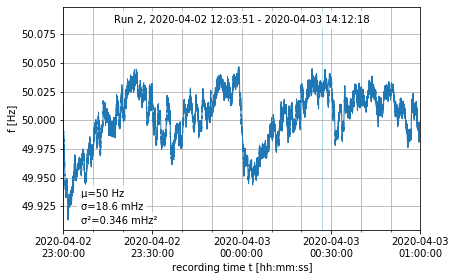

In [90]:
plot_freq_trace('freq_meas_trace_2h_1',
                xlim=[pdate('2020-04-02 23:00:00'), pdate('2020-04-03 01:00:00')],
               minor_locator=dates.MinuteLocator(interval=10),
               major_locator=dates.MinuteLocator(interval=30))

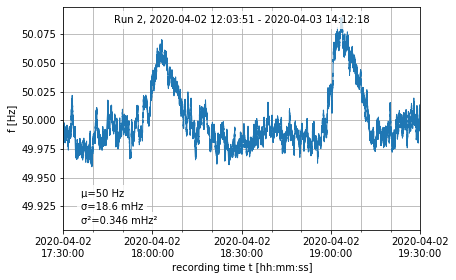

In [91]:
plot_freq_trace('freq_meas_trace_2h_2',
                xlim=[pdate('2020-04-02 17:30'), pdate('2020-04-02 19:30:00')],
               minor_locator=dates.MinuteLocator(interval=10),
               major_locator=dates.MinuteLocator(interval=30))

In [12]:
def compute_voltage_fft(data):
    # Number of samplepoints
    N = len(data)
    # sample spacing
    T = 1.0 / sampling_rate
    x = np.linspace(0.0, N*T, N)
    yf = scipy.fftpack.fft(data * sig.blackman(N))
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

    yf = 2.0/N * np.abs(yf[:N//2])

    average_from = lambda val, start, average_width: np.hstack([val[:start], [ np.mean(val[i:i+average_width]) for i in range(start, len(val), average_width) ]])

    average_width = 6
    average_start = 20
    yf = average_from(yf, average_start, average_width)
    xf = average_from(xf, average_start, average_width)
    yf = average_from(yf, 200, average_width)
    xf = average_from(xf, 200, average_width)
    return xf, yf
voltage_fft = compute_voltage_fft(data_interp)

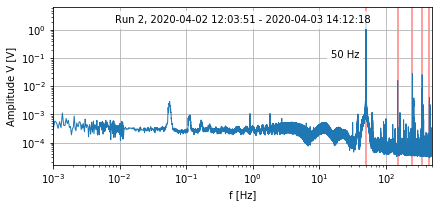

In [65]:
def plot_voltage_spectrum(xf, yf):
    fig, ax = plt.subplots(figsize=(6, 3))
    fig.tight_layout()

    yf2 = np.copy(yf)
    #chunk_size = 200
    #for i in range(len(yf)-chunk_size, 1, -chunk_size):
    #    yf2 = np.hstack([yf2[:i], sig.savgol_filter(yf2[i:], 23, 3)])

    ax.loglog(xf, yf2, lw=1)
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _pos: f'{1/x:.1f}'))
    ax.set_xlabel('f [Hz]')
    ax.set_ylabel('Amplitude V [V]')
    ax.grid()
    ax.set_xlim([0.001, 500])
    fig.subplots_adjust(bottom=0.2)

    for le_f in (50, 150, 250, 350, 450):
        ax.axvline(le_f, color=(1, 0.5, 0.5), zorder=-2)
    ax.annotate('50 Hz', xy=(15, 0.1), xycoords='data', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.5, 0.9, f'Run {run_id}, {time_window}', transform=ax.transAxes, ha='center', bbox=dict(fc='white', alpha=0.8, ec='none'))
    fig.savefig('fig_out/mains_voltage_spectrum.pdf')
plot_voltage_spectrum(*voltage_fft)

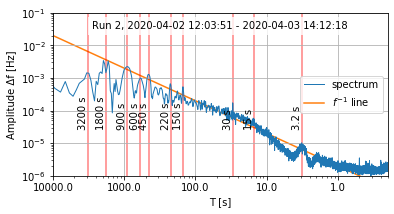

In [64]:
def plot_fmeas_spectrum(data):
    # Number of samplepoints
    newcopy = np.copy(data)
    nans, x = nan_helper(newcopy)
    newcopy[nans]= np.interp(x(nans), x(~nans), newcopy[~nans])

    N = len(newcopy)
    # sample spacing
    T = 1.0 / 10
    x = np.linspace(0.0, N*T, N)
    yf = scipy.fftpack.fft(newcopy * sig.blackman(N))
    xf = np.linspace(0.0, 10/2, N//2)

    yf = 2.0/N * np.abs(yf[:N//2])

    chunk_size = 200
    for i in range(len(yf)-chunk_size, 1, -chunk_size):
        yf = np.hstack([yf[:i], sig.savgol_filter(yf[i:], 23, 3)])

    fig, ax = plt.subplots(figsize=(6,3))
    ax.loglog(xf, yf, label='spectrum', lw=1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _pos: f'{1/x:.1f}'))
    ax.set_xlabel('T [s]')
    ax.set_ylabel('Amplitude Δf [Hz]')

    for i, t in enumerate([3.2, 15, 30, 150, 220, 450, 600, 900, 1800, 3200]):
        ax.axvline(1/t, color='red', alpha=0.5, zorder=-1)
        ax.annotate(f'{t} s', xy=(1/t, 3e-5), xytext=(-10, 0), xycoords='data', textcoords='offset pixels', rotation=90)
    #ax.text(1/60, 10,'60 s', ha='left')
    ax.grid()
    ax.set_xlim([1/10000, 5])
    ax.set_ylim([1e-6, 1e-1])
    ax.plot(xf[1:], 2e-6/xf[1:], zorder=-2, label='$f^{-1}$ line')
    ax.text(0.5, 0.9, f'Run {run_id}, {time_window}', transform=ax.transAxes, ha='center', bbox=dict(fc='white', alpha=0.8, ec='none'))

    ax.legend(loc='right')
    fig.savefig('fig_out/freq_meas_spectrum.pdf')
plot_fmeas_spectrum(f_mean)

# References

1. **Gasior, M. & Gonzalez, J.** Improving FFT frequency measurement resolution by parabolic and gaussian interpolation *CERN-AB-Note-2004-021, CERN-AB-Note-2004-021, 2004*